# Identifica relação de demanda com indicadores socioeconômicos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Utilizando o engine 'openpyxl' para ler o arquivo Excel
rotas_potenciais = pd.read_excel(
    'data/excel/xlsx/Estudo Rotas Potenciais.xlsx', 
    engine='openpyxl'  # Usar o openpyxl para leitura
)

In [3]:
# Utilizando o engine 'openpyxl' para ler o arquivo Excel
base_municipios = pd.read_excel(
    'data/excel/xlsx/Lista de municipios e UTPs.xlsx', 
    engine='openpyxl'  # Usar o openpyxl para leitura
)

In [4]:
base_municipios.columns

Index(['idMunicipio', 'codigo', 'nome', 'uf', 'idUtp', 'utp'], dtype='object')

In [5]:
matriz_od= pd.read_csv('data/csv/matriz_od_turismo.csv', delimiter = ',')

In [6]:
list(rotas_potenciais.columns)

['O',
 'D',
 'Soma de Aéreo',
 'Soma de Não aéreo',
 'Soma de Dúvida',
 'Total',
 'Origem',
 'Destino',
 'Share Aéreo %',
 'Lat O',
 'Long O',
 'Lat D',
 'Long D',
 'Distância aérea',
 'Classe de distância (até)',
 'Estranho',
 '% Pop O acima de 2 SM',
 '% Pop D acima de 2 SM',
 'Demanda potencial (novas ligações)',
 'Demanda potencial (adicional)',
 'Demanda potencial considerada atualizada 2019',
 'Filtro rotas potenciais',
 'Voos comerciais 2019',
 'Chave',
 'demanda anualizada anac (2019)',
 'UTP com aeroportos previstos no PAN O',
 'UTP com aeroportos previstos no PAN D',
 'Cenário PAN 2018-2038 + operantes 2019',
 'IBGE sede da UTP O',
 'IBGE sede da UTP D',
 'Aeroporto mais próximo da ponta sem atendimento',
 'Chave.1',
 'Tempo até o aero mais próximo (Min)',
 'Fator custo',
 'Demanda migrada para o aeroporto mais próximo (grav)',
 'UTP do aeroporto alimentado',
 'Rota alimentada',
 'Demanda acrescida de UTPs próximas',
 'Coordenadas',
 'X A',
 'Y A',
 'X B',
 'Y B',
 'Geom|Chav

In [7]:
distancia_classes_unicas = sorted(rotas_potenciais['Classe de distância (até)'].unique())
distancia_classes_unicas

[60.0, 100.0, 250.0, 500.0, 750.0, 1000.0, 5000.0, nan]

In [8]:
def filtrar_e_renomear_rotas_potenciais(df, base_municipios):
    # Dicionário de renomeação
    renomeacao = {
        'Origem': 'origem',
        'UF O': 'uf_origem',
        'Destino': 'destino',
        'UF D': 'uf_destino',
        'Soma de Aéreo': 'demanda_aero',
        'Soma de Não aéreo': 'demanda_rodo',
        'Soma de Dúvida': 'demanda_reprimida',
        'Total': 'demanda_total',
        'Share Aéreo %': 'share_aero',
        'Demanda potencial (novas ligações)': 'potencial_nova_lig',
        'Demanda potencial (adicional)': 'potencial_adicional',
        'Distância aérea': 'distancia',
        'Tarifa média': 'tarifa',
        '% Pop O acima de 2 SM': 'pop_acima_2sm_origem',
        '% Pop D acima de 2 SM': 'pop_acima_2sm_destino'
    }
    
    # Renomear colunas de acordo com o dicionário
    df.rename(columns=renomeacao, inplace=True)

    # Remover linhas onde 'origem' ou 'destino' são NaN
    df = df.dropna(subset=['origem', 'destino'])

    # Corrigir o nome "São João Del Rei" para "São João del Rei" em base_municipios
    base_municipios['nome'] = base_municipios['nome'].replace("São João Del Rei", "São João del Rei")

    # Criar uma coluna de chave de correspondência em base_municipios
    base_municipios['chave'] = base_municipios['nome'] + ' - ' + base_municipios['uf']

    # Adicionar 'cod_mun_origem' com base na correspondência entre 'origem' e 'chave'
    df = df.merge(base_municipios[['chave', 'codigo']], left_on='origem', right_on='chave', how='left').rename(
        columns={'codigo': 'cod_mun_origem'}).drop(columns=['chave'])

    # Adicionar 'cod_mun_destino' com base na correspondência entre 'destino' e 'chave'
    df = df.merge(base_municipios[['chave', 'codigo']], left_on='destino', right_on='chave', how='left').rename(
        columns={'codigo': 'cod_mun_destino'}).drop(columns=['chave'])

    # Colunas desejadas no DataFrame final
    colunas_desejadas = [
        'origem', 'cod_mun_origem', 'uf_origem',
        'cod_mun_destino', 'destino', 'uf_destino',
        'demanda_aero', 'demanda_rodo', 'demanda_reprimida',
        'demanda_total', 'share_aero', 'potencial_nova_lig',
        'potencial_adicional', 'distancia', 'tarifa',
        'pop_acima_2sm_origem', 'pop_acima_2sm_destino'
    ]
    
    # Filtrar o DataFrame para conter apenas as colunas desejadas
    colunas_presentes = [col for col in colunas_desejadas if col in df.columns]
    
    # Reorganizar e filtrar o DataFrame final
    df_filtrado = df[colunas_presentes].copy()

    return df_filtrado

In [9]:
rotas_potenciais_filtrado = filtrar_e_renomear_rotas_potenciais(rotas_potenciais, base_municipios)

In [10]:
rotas_potenciais_filtrado.columns

Index(['origem', 'cod_mun_origem', 'uf_origem', 'cod_mun_destino', 'destino',
       'uf_destino', 'demanda_aero', 'demanda_rodo', 'demanda_reprimida',
       'demanda_total', 'share_aero', 'potencial_nova_lig',
       'potencial_adicional', 'distancia', 'tarifa', 'pop_acima_2sm_origem',
       'pop_acima_2sm_destino'],
      dtype='object')

In [11]:
matriz_od.columns

Index(['mun_origem', 'mun_destino', 'distancia', 'pib_origem', 'pib_destino',
       'pop_origem', 'pop_destino', 'turismo_origem', 'turismo_destino'],
      dtype='object')

In [12]:
def calcular_pib_per_capita(matriz_od):
    matriz_od['pib_per_capita_origem'] = matriz_od['pib_origem'] / matriz_od['pop_origem']
    matriz_od['pib_per_capita_destino'] = matriz_od['pib_destino'] / matriz_od['pop_destino']
    return matriz_od

matriz_od = calcular_pib_per_capita(matriz_od)

In [13]:
def remover_infinitos_e_nulos(matriz_od):
    matriz_od.replace([np.inf, -np.inf], pd.NA, inplace=True)
    matriz_od.dropna(subset=['pib_per_capita_origem', 'pib_per_capita_destino'], inplace=True)
    return matriz_od

matriz_od = remover_infinitos_e_nulos(matriz_od)

In [14]:
def definir_classes_distancia_otimizada(matriz_od, distancia_classes_unicas):
    # Remover NaN e ordenar a lista de classes de distância
    distancia_classes_unicas = sorted([x for x in distancia_classes_unicas if pd.notna(x)])
    
    # Definir limites e rótulos com base na lista fornecida
    limites = [-float('inf')] + distancia_classes_unicas + [float('inf')]
    rotulos = [f"até {limites[1]}"] + \
              [f"entre {limites[i]} e {limites[i + 1]}" for i in range(1, len(limites) - 2)] + \
              [f"acima de {limites[-2]}"]

    # Adicionar a coluna classe_distancia diretamente no DataFrame sem cópia
    matriz_od['classe_distancia'] = pd.cut(matriz_od['distancia'], bins=limites, labels=rotulos, right=True)

    return matriz_od

matriz_od = definir_classes_distancia_otimizada(matriz_od, distancia_classes_unicas)

In [15]:
def criar_variaveis_dummy_classe_distancia(matriz_od):
    dummies_classe_distancia = pd.get_dummies(matriz_od['classe_distancia'], prefix='classe_distancia', drop_first=True)
    matriz_od = pd.concat([matriz_od, dummies_classe_distancia], axis=1)
    return matriz_od

matriz_od = criar_variaveis_dummy_classe_distancia(matriz_od)

In [16]:
# Lista de classes populacionais atualizadas
pop_classes_unicas = [10000, 25000, 50000, 100000, 250000, 500000, 1000000, 3000000]

In [17]:
def definir_classes_populacao(matriz_od, pop_classes_unicas):
    # Ordenar e definir limites e rótulos com base nas classes fornecidas
    pop_classes_unicas = sorted([x for x in pop_classes_unicas if pd.notna(x)])
    limites = [-float('inf')] + pop_classes_unicas + [float('inf')]
    rotulos = [f"até {limites[1]}"] + \
              [f"entre {limites[i]} e {limites[i + 1]}" for i in range(1, len(limites) - 2)] + \
              [f"acima de {limites[-2]}"]

    # Adicionar colunas de classe para pop_origem e pop_destino
    matriz_od['classe_pop_origem'] = pd.cut(matriz_od['pop_origem'], bins=limites, labels=rotulos, right=True)
    matriz_od['classe_pop_destino'] = pd.cut(matriz_od['pop_destino'], bins=limites, labels=rotulos, right=True)

    return matriz_od

matriz_od = definir_classes_populacao(matriz_od, pop_classes_unicas)

In [18]:
def criar_variaveis_dummy_classe_populacao(matriz_od):
    # Criar variáveis dummy para classe_pop_origem e classe_pop_destino
    dummies_origem = pd.get_dummies(matriz_od['classe_pop_origem'], prefix='classe_pop_origem', drop_first=True)
    dummies_destino = pd.get_dummies(matriz_od['classe_pop_destino'], prefix='classe_pop_destino', drop_first=True)

    # Concatenar as dummies com o DataFrame original
    matriz_od = pd.concat([matriz_od, dummies_origem, dummies_destino], axis=1)
    
    return matriz_od

matriz_od = criar_variaveis_dummy_classe_populacao(matriz_od)

In [19]:
def adicionar_demandas_matriz_od(matriz_od, rotas_potenciais_filtrado):
    # Selecionar as colunas relevantes de rotas_potenciais_filtrado
    colunas_selecionadas = [
        'cod_mun_origem', 'cod_mun_destino', 'demanda_aero', 'demanda_rodo', 
        'demanda_reprimida', 'demanda_total', 'share_aero', 'tarifa', 
        'pop_acima_2sm_origem', 'pop_acima_2sm_destino'
    ]
    rotas_selecionadas = rotas_potenciais_filtrado[colunas_selecionadas]
    
    # Realizar o merge utilizando as correspondências e preservando apenas as linhas com correspondência
    matriz_od_avaliacao = matriz_od.merge(
        rotas_selecionadas,
        left_on=['mun_origem', 'mun_destino'],
        right_on=['cod_mun_origem', 'cod_mun_destino'],
        how='inner'  # Apenas linhas com correspondência serão mantidas
    )
    
    # Remover as colunas de chave extras (cod_mun_origem e cod_mun_destino) após o merge
    matriz_od_avaliacao = matriz_od_avaliacao.drop(columns=['cod_mun_origem', 'cod_mun_destino'])
        
    return matriz_od_avaliacao

matriz_od_avaliacao = adicionar_demandas_matriz_od(matriz_od, rotas_potenciais_filtrado)

In [20]:
matriz_od_avaliacao.columns

Index(['mun_origem', 'mun_destino', 'distancia', 'pib_origem', 'pib_destino',
       'pop_origem', 'pop_destino', 'turismo_origem', 'turismo_destino',
       'pib_per_capita_origem', 'pib_per_capita_destino', 'classe_distancia',
       'classe_distancia_entre 60.0 e 100.0',
       'classe_distancia_entre 100.0 e 250.0',
       'classe_distancia_entre 250.0 e 500.0',
       'classe_distancia_entre 500.0 e 750.0',
       'classe_distancia_entre 750.0 e 1000.0',
       'classe_distancia_entre 1000.0 e 5000.0',
       'classe_distancia_acima de 5000.0', 'classe_pop_origem',
       'classe_pop_destino', 'classe_pop_origem_entre 10000 e 25000',
       'classe_pop_origem_entre 25000 e 50000',
       'classe_pop_origem_entre 50000 e 100000',
       'classe_pop_origem_entre 100000 e 250000',
       'classe_pop_origem_entre 250000 e 500000',
       'classe_pop_origem_entre 500000 e 1000000',
       'classe_pop_origem_entre 1000000 e 3000000',
       'classe_pop_origem_acima de 3000000',
       '

In [21]:
def calcular_regressao_demanda_total(matriz_od_avaliacao):
    # Criar as colunas log-transformadas caso elas ainda não existam
    if 'pib_origem_log' not in matriz_od_avaliacao.columns:
        matriz_od_avaliacao['pib_origem_log'] = np.log(matriz_od_avaliacao['pib_origem'] + 1e-9)
    if 'pib_destino_log' not in matriz_od_avaliacao.columns:
        matriz_od_avaliacao['pib_destino_log'] = np.log(matriz_od_avaliacao['pib_destino'] + 1e-9)
    
    # Remover quaisquer linhas com NaN ou inf
    matriz_od_avaliacao = matriz_od_avaliacao.replace([np.inf, -np.inf], np.nan).dropna(subset=[
        'pib_origem_log', 'pib_destino_log', 'turismo_origem', 'turismo_destino', 'demanda_total'
    ])
    
    # Incluir as dummies de classe_distancia, classe_pop_origem e classe_pop_destino
    dummies_classe_distancia = pd.get_dummies(matriz_od_avaliacao['classe_distancia'], prefix='classe_distancia', drop_first=True)
    dummies_classe_pop_origem = pd.get_dummies(matriz_od_avaliacao['classe_pop_origem'], prefix='classe_pop_origem', drop_first=True)
    dummies_classe_pop_destino = pd.get_dummies(matriz_od_avaliacao['classe_pop_destino'], prefix='classe_pop_destino', drop_first=True)
    
    # Garantir que as dummies sejam do tipo float
    dummies_classe_distancia = dummies_classe_distancia.astype(float)
    dummies_classe_pop_origem = dummies_classe_pop_origem.astype(float)
    dummies_classe_pop_destino = dummies_classe_pop_destino.astype(float)
    
    # Variáveis independentes para demanda_total
    X_demanda_total = matriz_od_avaliacao[['pib_origem_log', 'pib_destino_log', 'turismo_origem', 'turismo_destino']]
    X_demanda_total = pd.concat([X_demanda_total, dummies_classe_distancia, dummies_classe_pop_origem, dummies_classe_pop_destino], axis=1)
    
    y_demanda_total = matriz_od_avaliacao['demanda_total']
    
    # Aplicar a transformação potencial apenas na variável dependente
    y_demanda_total = np.log(y_demanda_total + 1e-9)
    print("Ajustando o modelo potencial...")

    # Adicionar constante para o termo de intercepto
    X_demanda_total = sm.add_constant(X_demanda_total)
    
    # Ajustar o modelo de regressão para demanda_total
    modelo_demanda_total = sm.OLS(y_demanda_total, X_demanda_total).fit()
    print("\nResumo do modelo potencial:")
    print(modelo_demanda_total.summary())
    
    return modelo_demanda_total

# Executar o modelo potencial
modelo_demanda_total = calcular_regressao_demanda_total(matriz_od_avaliacao)

Ajustando o modelo potencial...

Resumo do modelo potencial:
                            OLS Regression Results                            
Dep. Variable:          demanda_total   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     4504.
Date:                Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                        01:25:50   Log-Likelihood:            -1.2612e+05
No. Observations:               68905   AIC:                         2.523e+05
Df Residuals:                   68878   BIC:                         2.525e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [22]:
def prever_demanda_total(matriz_od, modelo_demanda_total):
    # Verificar e criar colunas log-transformadas para PIB, caso ainda não existam
    if 'pib_origem_log' not in matriz_od.columns:
        matriz_od['pib_origem_log'] = np.log(matriz_od['pib_origem'] + 1e-9)
    if 'pib_destino_log' not in matriz_od.columns:
        matriz_od['pib_destino_log'] = np.log(matriz_od['pib_destino'] + 1e-9)
    
    # Selecionar as colunas necessárias, incluindo as transformadas e variáveis relevantes
    cols_necessarias = ['pib_origem_log', 'pib_destino_log', 'turismo_origem', 'turismo_destino']
    matriz_simplificada = matriz_od[cols_necessarias].copy()

    # Identificar as dummies esperadas pelo modelo
    dummies_classe_distancia = [col for col in modelo_demanda_total.params.index if col.startswith('classe_distancia_')]
    dummies_classe_pop_origem = [col for col in modelo_demanda_total.params.index if col.startswith('classe_pop_origem_')]
    dummies_classe_pop_destino = [col for col in modelo_demanda_total.params.index if col.startswith('classe_pop_destino_')]

    # Garantir que todas as dummies estão presentes no DataFrame, preenchendo valores ausentes com 0
    dummies_df_distancia = matriz_od.reindex(columns=dummies_classe_distancia, fill_value=0).astype('float32')
    dummies_df_pop_origem = matriz_od.reindex(columns=dummies_classe_pop_origem, fill_value=0).astype('float32')
    dummies_df_pop_destino = matriz_od.reindex(columns=dummies_classe_pop_destino, fill_value=0).astype('float32')
    
    # Concatenar dummies às variáveis explicativas
    X_demanda_total = pd.concat([matriz_simplificada, dummies_df_distancia, dummies_df_pop_origem, dummies_df_pop_destino], axis=1)

    # Adicionar constante para o termo de intercepto
    X_demanda_total = sm.add_constant(X_demanda_total, has_constant='add')

    # Prever a demanda total usando o modelo treinado (com transformação logarítmica)
    demanda_prevista_log = modelo_demanda_total.predict(X_demanda_total)
    
    # Aplicar a exponencial inversa para transformar de volta à escala original
    demanda_prevista = np.exp(demanda_prevista_log) - 1e-9  # Reverter a transformação logarítmica

    # Adicionar a previsão à matriz_od
    matriz_od['demanda_total_previsto'] = demanda_prevista

    return matriz_od

# Chamar a função com o modelo treinado
matriz_od = prever_demanda_total(matriz_od, modelo_demanda_total)

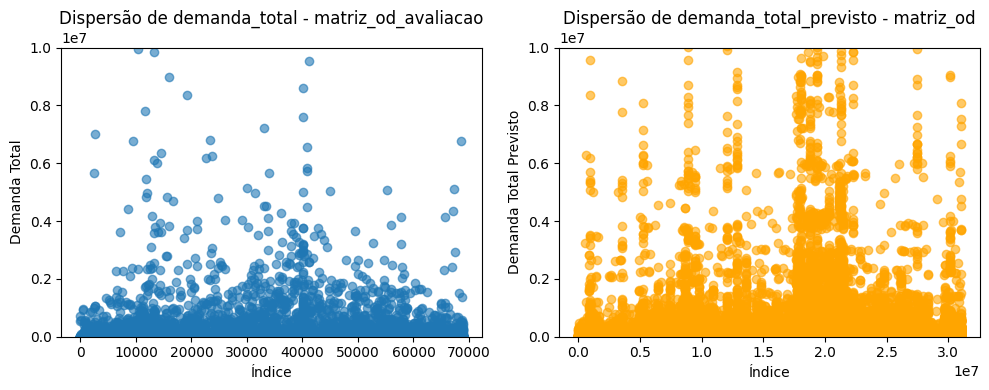

In [23]:
def plotar_graficos_dispersao(matriz_od_avaliacao, matriz_od):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Gráfico de dispersão para demanda_total no DataFrame matriz_od_avaliacao
    axs[0].scatter(matriz_od_avaliacao.index, matriz_od_avaliacao['demanda_total'], alpha=0.6)
    axs[0].set_title('Dispersão de demanda_total - matriz_od_avaliacao')
    axs[0].set_xlabel('Índice')
    axs[0].set_ylabel('Demanda Total')

    # Gráfico de dispersão para demanda_total_previsto no DataFrame matriz_od
    axs[1].scatter(matriz_od.index, matriz_od['demanda_total_previsto'], alpha=0.6, color='orange')
    axs[1].set_title('Dispersão de demanda_total_previsto - matriz_od')
    axs[1].set_xlabel('Índice')
    axs[1].set_ylabel('Demanda Total Previsto')

    # Definir o mesmo limite de y para ambos os gráficos com base na matriz_od_avaliacao
    y_min = 0
    y_max = 10000000
    
    axs[0].set_ylim(y_min, y_max)
    axs[1].set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()

# Chame a função com os DataFrames apropriados
plotar_graficos_dispersao(matriz_od_avaliacao, matriz_od)

In [24]:
def calcular_regressao_share_aero(matriz_od_avaliacao):
    # Remover quaisquer linhas com NaN ou inf
    matriz_od_avaliacao = matriz_od_avaliacao.replace([np.inf, -np.inf], np.nan).dropna(subset=[
        'pib_origem', 'pib_destino', 'pib_per_capita_origem', 'pib_per_capita_destino', 'share_aero'
    ])
    
    # Incluir as dummies de classe_distancia
    dummies_classe_distancia = pd.get_dummies(matriz_od_avaliacao['classe_distancia'], prefix='classe_distancia', drop_first=True)
    dummies_classe_distancia = dummies_classe_distancia.astype(float)
    
    # Variáveis independentes para share_aero
    X_share_aero = matriz_od_avaliacao[['pib_origem', 'pib_destino']]
    X_share_aero = pd.concat([X_share_aero, dummies_classe_distancia], axis=1)
    
    # Variável dependente
    y_share_aero = matriz_od_avaliacao['share_aero']
    
    # Ajustar o modelo de regressão linear para share_aero
    print("Ajustando o modelo linear para share_aero...")
    modelo_share_aero = sm.OLS(y_share_aero, X_share_aero).fit()
    print("\nResumo do modelo linear para share_aero:")
    print(modelo_share_aero.summary())
    
    return modelo_share_aero

modelo_share_aero = calcular_regressao_share_aero(matriz_od_avaliacao)

Ajustando o modelo linear para share_aero...

Resumo do modelo linear para share_aero:
                                 OLS Regression Results                                
Dep. Variable:             share_aero   R-squared (uncentered):                   0.659
Model:                            OLS   Adj. R-squared (uncentered):              0.659
Method:                 Least Squares   F-statistic:                          1.661e+04
Date:                Mon, 18 Nov 2024   Prob (F-statistic):                        0.00
Time:                        01:29:25   Log-Likelihood:                         -7718.7
No. Observations:               68905   AIC:                                  1.545e+04
Df Residuals:                   68897   BIC:                                  1.553e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                                 

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [25]:
def prever_share_aero(matriz_od, modelo_share_aero):
    # Selecionar as variáveis explicativas básicas
    X_share_aero = matriz_od[['pib_origem', 'pib_destino']]

    # Identificar as dummies esperadas pelo modelo
    dummies_classe_distancia = [col for col in modelo_share_aero.model.exog_names if col.startswith('classe_distancia_')]

    # Garantir que todas as dummies estão presentes no DataFrame, preenchendo valores ausentes com 0
    dummies_df_distancia = matriz_od.reindex(columns=dummies_classe_distancia, fill_value=0).astype('float32')

    # Concatenar dummies às variáveis explicativas
    X_share_aero = pd.concat([X_share_aero, dummies_df_distancia], axis=1)

    # Adicionar constante para o termo de intercepto
    X_share_aero = sm.add_constant(X_share_aero, has_constant='add')

    # Garantir que a ordem das colunas de X_share_aero é a mesma usada no modelo
    X_share_aero = X_share_aero[modelo_share_aero.model.exog_names]

    # Prever share_aero usando o modelo treinado
    matriz_od['share_aero_previsto'] = modelo_share_aero.predict(X_share_aero)

    # Limitar os valores de share_aero_previsto entre 0 e 1 (0% a 100%)
    matriz_od['share_aero_previsto'] = matriz_od['share_aero_previsto'].clip(lower=0, upper=1)

    return matriz_od

# Executar a função para prever share_aero
matriz_od = prever_share_aero(matriz_od, modelo_share_aero)

In [26]:
def calcular_demanda_aerea(matriz_od):
    # Calcular demanda_aerea_previsto
    matriz_od['demanda_aerea_previsto'] = matriz_od['demanda_total_previsto'] * matriz_od['share_aero_previsto']
    
    # Remover as colunas especificadas
    colunas_para_remover = [
        'classe_distancia_entre 60.0 e 100.0',
        'classe_distancia_entre 100.0 e 250.0',
        'classe_distancia_entre 250.0 e 500.0',
        'classe_distancia_entre 500.0 e 750.0',
        'classe_distancia_entre 750.0 e 1000.0',
        'classe_distancia_entre 1000.0 e 5000.0',
        'classe_distancia_acima de 5000.0',
        'classe_pop_origem_entre 10000 e 25000',
        'classe_pop_origem_entre 25000 e 50000',
        'classe_pop_origem_entre 50000 e 100000',
        'classe_pop_origem_entre 100000 e 250000',
        'classe_pop_origem_entre 250000 e 500000',
        'classe_pop_origem_entre 500000 e 1000000',
        'classe_pop_origem_entre 1000000 e 3000000',
        'classe_pop_origem_acima de 3000000',
        'classe_pop_destino_entre 10000 e 25000',
        'classe_pop_destino_entre 25000 e 50000',
        'classe_pop_destino_entre 50000 e 100000',
        'classe_pop_destino_entre 100000 e 250000',
        'classe_pop_destino_entre 250000 e 500000',
        'classe_pop_destino_entre 500000 e 1000000',
        'classe_pop_destino_entre 1000000 e 3000000',
        'classe_pop_destino_acima de 3000000',
        'pib_origem_log',
        'pib_destino_log'
    ]
    matriz_od = matriz_od.drop(columns=colunas_para_remover, errors='ignore')
    
    return matriz_od

# Executar a função para calcular demanda_aerea e remover colunas
matriz_od_completa = calcular_demanda_aerea(matriz_od)

In [ ]:
matriz_od_completa.column

Index(['mun_origem', 'mun_destino', 'distancia', 'pib_origem', 'pib_destino',
       'pop_origem', 'pop_destino', 'turismo_origem', 'turismo_destino',
       'pib_per_capita_origem', 'pib_per_capita_destino', 'classe_distancia',
       'classe_pop_origem', 'classe_pop_destino', 'demanda_total_previsto',
       'share_aero_previsto', 'demanda_aerea_previsto'],
      dtype='object')